In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split, cross_val_score, GridSearchCV, KFold
)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

data cleaning


In [40]:
df = pd.read_csv('insuranceWithFeatures.csv')

print('Dataset shape:', df.shape)
df.head()

Dataset shape: (1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [41]:
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing (%)': missing_pct.round(2)
})

print('Missing value summary:')
print(missing_df)

if missing.sum() == 0:
    print('\nNo missing values found')
else:
    print('\nMissing values detected')

Missing value summary:
          Missing Count  Missing (%)
age                   0          0.0
sex                   0          0.0
bmi                   0          0.0
children              0          0.0
smoker                0          0.0
region                0          0.0
charges               0          0.0

No missing values found


In [42]:
print('Data types:')
print(df.dtypes)
print()
print('Summary statistics:')
df.describe(include='all')

Data types:
age           int64
sex             str
bmi         float64
children      int64
smoker          str
region          str
charges     float64
dtype: object

Summary statistics:


,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338,1338.000000,1338.000000,1338,1338,1338.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,676,NaN,NaN,1064,364,NaN
mean,39.207025,NaN,30.663397,1.094918,NaN,NaN,13270.422265
std,14.049960,NaN,6.098187,1.205493,NaN,NaN,12110.011237
min,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,27.000000,NaN,26.296250,0.000000,NaN,NaN,4740.287150
50%,39.000000,NaN,30.400000,1.000000,NaN,NaN,9382.033000
75%,51.000000,NaN,34.693750,2.000000,NaN,NaN,16639.912515


In [43]:
df_clean = df.copy()

# Binary encoding for sex and smoker
df_clean['sex']    = df_clean['sex'].map({'male': 1, 'female': 0})
df_clean['smoker'] = df_clean['smoker'].map({'yes': 1, 'no': 0})

# encoding for region
df_clean = pd.get_dummies(df_clean, columns=['region'], drop_first=True)

print('Columns after encoding:')
print(df_clean.columns.tolist())
df_clean.head()

Columns after encoding:
['age', 'sex', 'bmi', 'children', 'smoker', 'charges', 'region_northwest', 'region_southeast', 'region_southwest']


,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,False,False,True
1,18,1,33.770,1,0,1725.55230,False,True,False
2,28,1,33.000,3,0,4449.46200,False,True,False
3,33,1,22.705,0,0,21984.47061,True,False,False
4,32,1,28.880,0,0,3866.85520,True,False,False


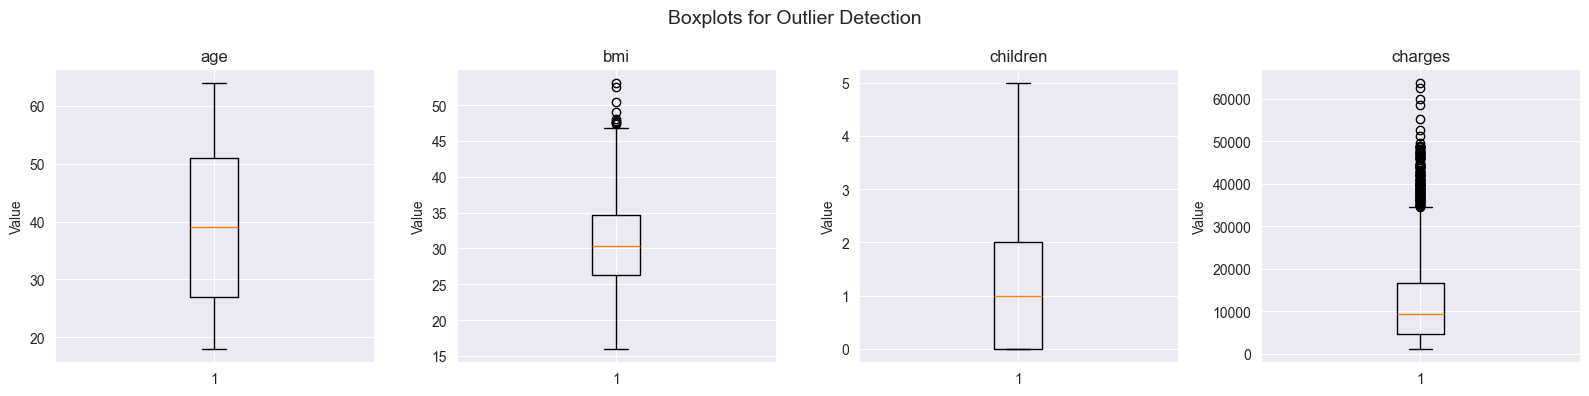

outlier counts:
  age: 0 outliers (bounds: [-9.00, 87.00])
  bmi: 9 outliers (bounds: [13.70, 47.29])
  children: 0 outliers (bounds: [-3.00, 5.00])
  charges: 139 outliers (bounds: [-13109.15, 34489.35])


In [44]:
numeric_cols = ['age', 'bmi', 'children', 'charges']

fig, axes = plt.subplots(1, len(numeric_cols), figsize=(16, 4))
fig.suptitle('Boxplots for Outlier Detection', fontsize=14)

for ax, col in zip(axes, numeric_cols):
    ax.boxplot(df_clean[col], vert=True)
    ax.set_title(col)
    ax.set_ylabel('Value')

plt.tight_layout()
plt.show()

# outlier counts
print('outlier counts:')
for col in numeric_cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    n_out = ((df_clean[col] < lower) | (df_clean[col] > upper)).sum()
    print(f'  {col}: {n_out} outliers (bounds: [{lower:.2f}, {upper:.2f}])')

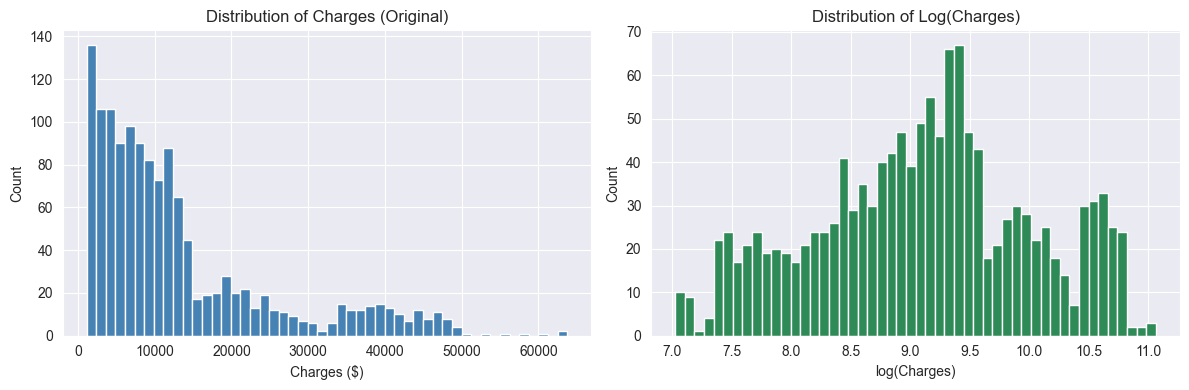

Skewness (original charges): 1.516
Skewness (log charges): -0.09


In [45]:
df_clean['log_charges'] = np.log1p(df_clean['charges'])

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(df_clean['charges'], bins=50, color='steelblue', edgecolor='white')
axes[0].set_title('Distribution of Charges (Original)')
axes[0].set_xlabel('Charges ($)')
axes[0].set_ylabel('Count')

axes[1].hist(df_clean['log_charges'], bins=50, color='seagreen', edgecolor='white')
axes[1].set_title('Distribution of Log(Charges)')
axes[1].set_xlabel('log(Charges)')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

print('Skewness (original charges):', round(df_clean['charges'].skew(), 3))
print('Skewness (log charges):',      round(df_clean['log_charges'].skew(), 3))

In [46]:
print(f'Final cleaned dataset shape: {df_clean.shape}')
print(f'No. of features (excl. targets): {df_clean.shape[1] - 2}')
print('\nColumn list:')
print(df_clean.columns.tolist())
#df_clean.to_csv('insurance_cleaned.csv', index=False)

Final cleaned dataset shape: (1338, 10)
No. of features (excl. targets): 8

Column list:
['age', 'sex', 'bmi', 'children', 'smoker', 'charges', 'region_northwest', 'region_southeast', 'region_southwest', 'log_charges']


model

In [47]:

df = pd.read_csv('insurance_cleaned.csv')

feature_cols = [c for c in df.columns if c not in ['charges', 'log_charges']]
X = df[feature_cols].values
y_log = df['log_charges'].values    # log-transformed
y_raw = df['charges'].values        # original dollar scale


X_train, X_temp, y_train, y_temp, y_raw_train, y_raw_temp = train_test_split(
    X, y_log, y_raw, test_size=0.20, random_state=42
)
X_val, X_test, y_val, y_test, y_raw_val, y_raw_test = train_test_split(
    X_temp, y_temp, y_raw_temp, test_size=0.50, random_state=42
)

print(f'Features:       {len(feature_cols)} → {feature_cols}')
print(f'Training set:   {X_train.shape[0]} samples')
print(f'Validation set: {X_val.shape[0]} samples')
print(f'Test set:       {X_test.shape[0]} samples')

Features:       8 → ['age', 'sex', 'bmi', 'children', 'smoker', 'region_northwest', 'region_southeast', 'region_southwest']
Training set:   1069 samples
Validation set: 134 samples
Test set:       134 samples


In [48]:

nn_unscaled = MLPRegressor(hidden_layer_sizes=(256), max_iter=500, random_state=42)
nn_unscaled.fit(X_train, y_train)
r2_unscaled = r2_score(y_val, nn_unscaled.predict(X_val))

nn_scaled = Pipeline([
    ('scaler', StandardScaler()),
    ('nn', MLPRegressor(hidden_layer_sizes=(256), max_iter=500, random_state=42))
])
nn_scaled.fit(X_train, y_train)
r2_scaled = r2_score(y_val, nn_scaled.predict(X_val))

print(f'R² WITHOUT scaling: {r2_unscaled:.4f}')
print(f'R² WITH scaling:    {r2_scaled:.4f}')

R² WITHOUT scaling: 0.7818
R² WITH scaling:    0.8561


In [49]:
architectures = {
    'Small (32)':           (32,),
    'Medium (64, 32)':      (64, 32),
    'Large (128, 64, 32)':  (128, 64, 32),
    'Wide (256)':           (256,),
}

arch_results = {}
print('Architecture Comparison — 5-Fold CV on Training Set (R²)')
print('=' * 60)

for name, layers in architectures.items():
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('nn', MLPRegressor(
            hidden_layer_sizes=layers,
            activation='relu',
            max_iter=500,
            random_state=42
        ))
    ])
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='r2')
    arch_results[name] = scores
    # Count parameters
    pipe.fit(X_train, y_train)
    nn_model = pipe.named_steps['nn']
    n_params = sum(w.size for w in nn_model.coefs_) + sum(b.size for b in nn_model.intercepts_)
    print(f'{name:<22}  R² = {scores.mean():.4f} ± {scores.std():.4f}  ({n_params} params)')

Architecture Comparison — 5-Fold CV on Training Set (R²)
Small (32)              R² = 0.7522 ± 0.0299  (321 params)
Medium (64, 32)         R² = 0.7883 ± 0.0309  (2689 params)
Large (128, 64, 32)     R² = 0.7932 ± 0.0205  (11521 params)
Wide (256)              R² = 0.8069 ± 0.0296  (2561 params)


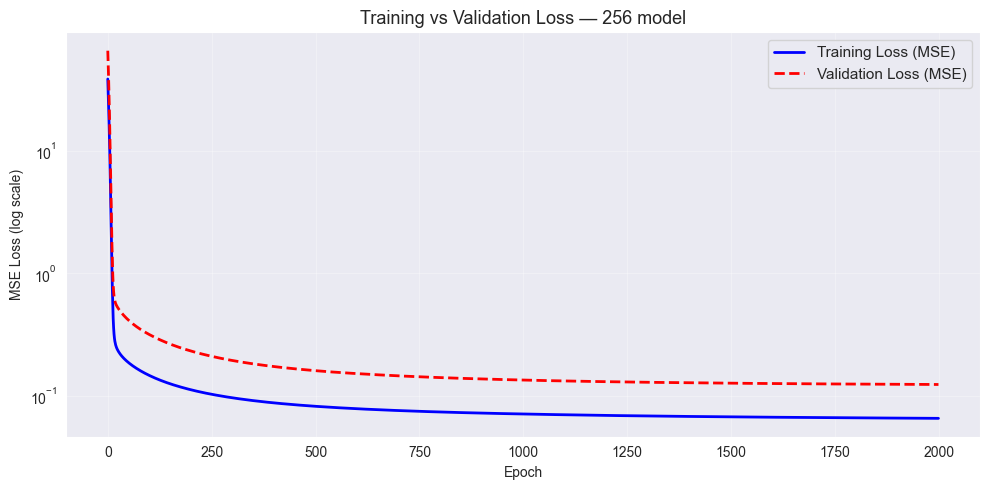

Final training loss:   0.0655
Final validation loss: 0.1238


In [50]:
scaler_check = StandardScaler()
X_train_sc = scaler_check.fit_transform(X_train)
X_val_sc   = scaler_check.transform(X_val)

nn_track = MLPRegressor(
    hidden_layer_sizes=(256),
    activation='relu',
    solver='sgd',
    max_iter=1,
    warm_start=True,
    random_state=42
)

train_losses, val_losses = [], []
n_epochs = 2000

for epoch in range(n_epochs):
    nn_track.fit(X_train_sc, y_train)
    train_losses.append(nn_track.loss_)
    val_pred = nn_track.predict(X_val_sc)
    val_losses.append(mean_squared_error(y_val, val_pred))

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(train_losses, label='Training Loss (MSE)', color='blue', linewidth=2)
ax.plot(val_losses,   label='Validation Loss (MSE)', color='red', linewidth=2, linestyle='--')
ax.set_title(f'Training vs Validation Loss — {256} model', fontsize=13)
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss (log scale)')
ax.set_yscale('log')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f'Final training loss:   {train_losses[-1]:.4f}')
print(f'Final validation loss: {val_losses[-1]:.4f}')

In [51]:
best_nn = Pipeline([
    ('scaler', StandardScaler()),
    ('nn', MLPRegressor(hidden_layer_sizes=(256), activation='relu',        #learning_rate='constant',
                        #learning_rate='invscaling',
                        learning_rate='adaptive',
        learning_rate_init=0.0005,
                          max_iter=500, random_state=42))
])
best_nn.fit(X_train, y_train)

y_pred_log = best_nn.predict(X_test)
y_pred_raw = np.expm1(y_pred_log)   # convet back from log scale

r2_log   = r2_score(y_test, y_pred_log)
mae_log  = mean_absolute_error(y_test, y_pred_log)

r2_raw   = r2_score(y_raw_test, y_pred_raw)
mae_raw  = mean_absolute_error(y_raw_test, y_pred_raw)

print(best_nn.named_steps['nn'].get_params())
print(f'Log-scale   R²:   {r2_log:.4f}')
print(f'Log-scale   MAE:  {mae_log:.4f}')
print()
print(f'Dollar-scale R²:   {r2_raw:.4f}')
print(f'Dollar-scale MAE:  ${mae_raw:,.2f}')

{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': 256, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0005, 'loss': 'squared_error', 'max_fun': 15000, 'max_iter': 500, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 42, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
Log-scale   R²:   0.8906
Log-scale   MAE:  0.1968

Dollar-scale R²:   0.8508
Dollar-scale MAE:  $2,815.56


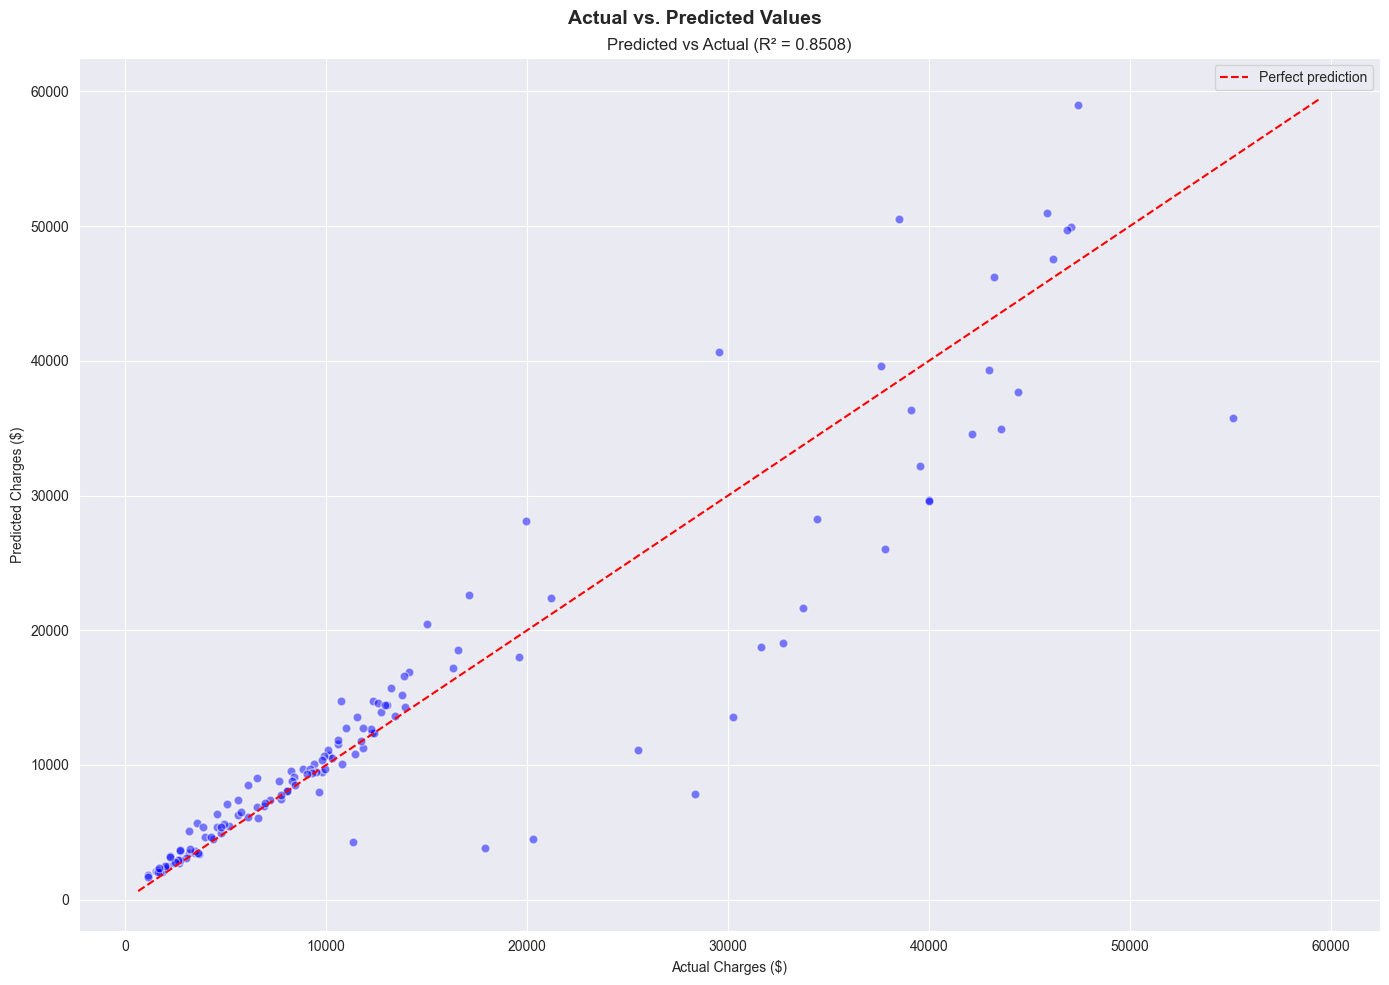

Residual mean:  $599.92
Residual std:   $5,175.72
Max error:      $20,461.82


In [52]:
residuals = y_raw_test - y_pred_raw

fig, ax = plt.subplots(1, 1, figsize=(14, 10))
fig.suptitle('Actual vs. Predicted Values', fontsize=14, fontweight='bold')

ax.scatter(y_raw_test, y_pred_raw, alpha=0.5,
           color='blue', edgecolors='white', s=40)

lims = [min(y_raw_test.min(), y_pred_raw.min()) - 500,
        max(y_raw_test.max(), y_pred_raw.max()) + 500]

ax.plot(lims, lims, 'r--', linewidth=1.5, label='Perfect prediction')

ax.set_xlabel('Actual Charges ($)')
ax.set_ylabel('Predicted Charges ($)')
ax.set_title(f'Predicted vs Actual (R² = {r2_raw:.4f})')
ax.legend()

plt.tight_layout()
plt.show()

print(f'Residual mean:  ${residuals.mean():,.2f}')
print(f'Residual std:   ${residuals.std():,.2f}')
print(f'Max error:      ${np.abs(residuals).max():,.2f}')

feature importance

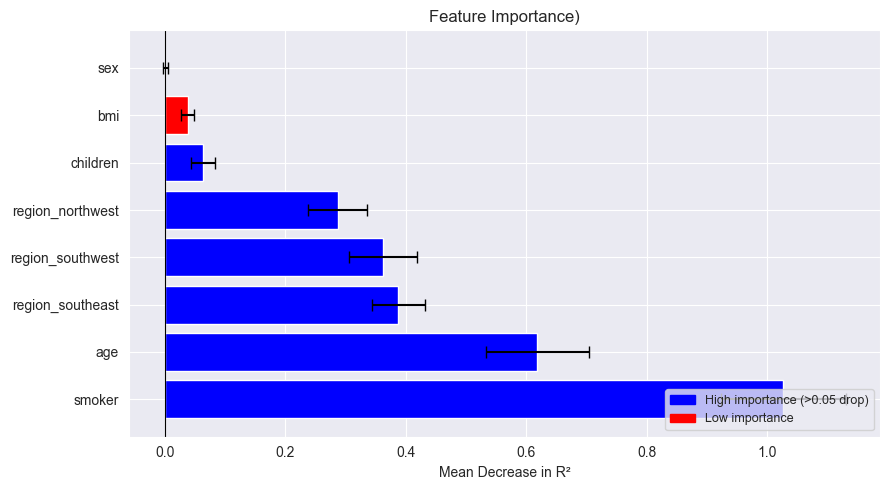


Feature Importance
---------------------------------------------
  smoker                    +1.0266 ± 0.1039
  age                       +0.6183 ± 0.0860
  region_southeast          +0.3876 ± 0.0435
  region_southwest          +0.3616 ± 0.0563
  region_northwest          +0.2868 ± 0.0486
  children                  +0.0632 ± 0.0199
  bmi                       +0.0378 ± 0.0110
  sex                       +0.0008 ± 0.0041


In [53]:
perm_result = permutation_importance(
    best_nn, X_test, y_test,
    n_repeats=30, random_state=42, scoring='r2'
)

sorted_idx = perm_result.importances_mean.argsort()[::-1]
sorted_names  = np.array(feature_cols)[sorted_idx]
sorted_means  = perm_result.importances_mean[sorted_idx]
sorted_stds   = perm_result.importances_std[sorted_idx]

fig, ax = plt.subplots(figsize=(9, 5))
colors_fi = ['blue' if m > 0.05 else 'red' for m in sorted_means]
ax.barh(sorted_names, sorted_means, xerr=sorted_stds,
        color=colors_fi, edgecolor='white', capsize=4)
ax.axvline(0, color='black', linewidth=0.8, linestyle='-')
ax.set_title('Feature Importance)',
             fontsize=12)
ax.set_xlabel('Mean Decrease in R²')

red_patch  = mpatches.Patch(color='blue', label='High importance (>0.05 drop)')
blue_patch = mpatches.Patch(color='red', label='Low importance')
ax.legend(handles=[red_patch, blue_patch], loc='lower right', fontsize=9)

plt.tight_layout()
plt.show()

print('\nFeature Importance')
print('-' * 45)
for name, mean, std in zip(sorted_names, sorted_means, sorted_stds):
    print(f'  {name:<25} {mean:+.4f} ± {std:.4f}')

Bootstrap 95% Confidence Intervals:
  R²:   [0.7797,  0.9034]   point estimate: 0.8508
  MAE:  [$2,105.41,  $3,560.78]   point estimate: $2,815.56


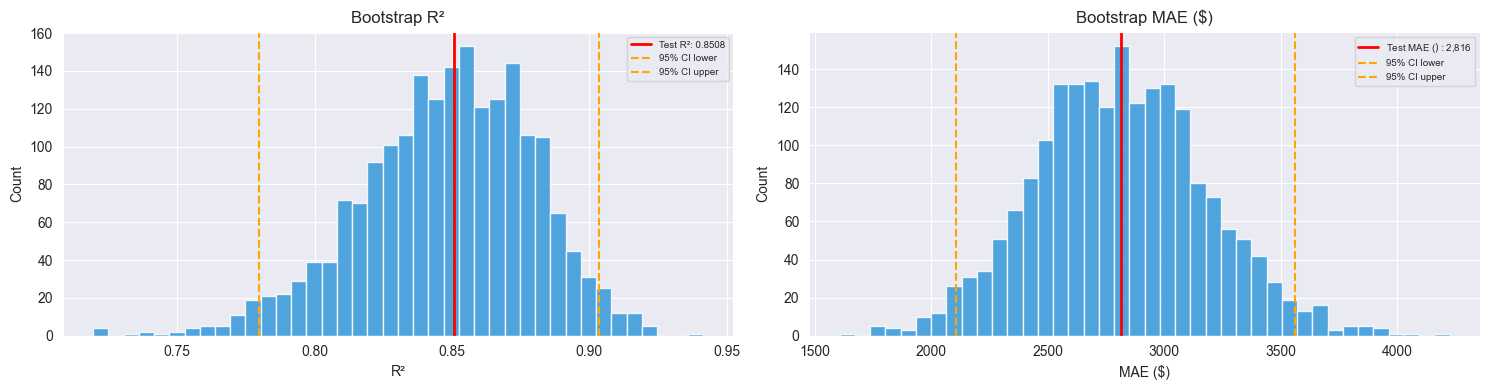

In [54]:
np.random.seed(42)
n_bootstrap = 2000
boot_r2, boot_mae = [], []

for _ in range(n_bootstrap):
    idx = np.random.choice(len(y_raw_test), size=len(y_raw_test), replace=True)
    boot_r2.append(r2_score(y_raw_test[idx], y_pred_raw[idx]))
    boot_mae.append(mean_absolute_error(y_raw_test[idx], y_pred_raw[idx]))

ci = {}
for name, data, point in [('R²', boot_r2, r2_raw),
                            ('MAE',  boot_mae,  mae_raw)]:
    lo, hi = np.percentile(data, [2.5, 97.5])
    ci[name] = (lo, hi, point)
print('Bootstrap 95% Confidence Intervals:')
print(f"  R²:   [{ci['R²'][0]:.4f},  {ci['R²'][1]:.4f}]   point estimate: {ci['R²'][2]:.4f}")
print(f"  MAE:  [${ci['MAE'][0]:,.2f},  ${ci['MAE'][1]:,.2f}]   point estimate: ${ci['MAE'][2]:,.2f}")

fig, axes = plt.subplots(1, 2, figsize=(15, 4))

for ax, (metric, data, point) in zip(axes, [
    ('R²', boot_r2, r2_raw),
    ('MAE ($)',  boot_mae,  mae_raw)
]):
    lo, hi = np.percentile(data, [2.5, 97.5])
    ax.hist(data, bins=40, color='#3498db', edgecolor='white', alpha=0.85)
    ax.axvline(point, color='red',    linestyle='-',  linewidth=2,   label=f'Test {metric}: {point:.4f}' if metric == 'R²' else f'Test {metric}: ${point:,.0f}')
    ax.axvline(lo,    color='orange', linestyle='--', linewidth=1.5, label=f'95% CI lower')
    ax.axvline(hi,    color='orange', linestyle='--', linewidth=1.5, label=f'95% CI upper')
    ax.set_title(f'Bootstrap {metric}')
    ax.set_xlabel(metric)
    ax.set_ylabel('Count')
    ax.legend(fontsize=7)

plt.tight_layout()
plt.show()

cross vaildation

In [55]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_r2   = cross_val_score(best_nn, X, y_log, cv=kf, scoring='r2')
cv_rmse = np.sqrt(-cross_val_score(best_nn, X, y_log, cv=kf,
                                    scoring='neg_mean_squared_error'))
cv_mae  = -cross_val_score(best_nn, X, y_log, cv=kf,
                            scoring='neg_mean_absolute_error')

print('\n5-Fold Cross-Validation Results — Neural Network')
print('=' * 52)
print(f"{'Fold':<8} {'R²':>8} {'MAE':>10}")
print('-' * 42)
for i, (r2, mae) in enumerate(zip(cv_r2, cv_mae), 1):
    print(f"Fold {i:<4} {r2:>8.4f} {mae:>10.4f}")
print('-' * 42)
print(f"{'Mean':<8} {cv_r2.mean():>8.4f} {cv_rmse.mean():>10.4f} {cv_mae.mean():>10.4f}")
print(f"{'Std':<8} {cv_r2.std():>8.4f} {cv_rmse.std():>10.4f} {cv_mae.std():>10.4f}")


5-Fold Cross-Validation Results — Neural Network
Fold           R²        MAE
------------------------------------------
Fold 1      0.8710     0.2092
Fold 2      0.7925     0.2268
Fold 3      0.7859     0.2261
Fold 4      0.8110     0.2260
Fold 5      0.8347     0.2056
------------------------------------------
Mean       0.8190     0.3882     0.2187
Std        0.0310     0.0289     0.0093
